### Visualizing the distribution of the observations

### Load the required libraries

In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
# sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12089
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|    47|[28 58 80 58 80 5...|2002.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|    28|[78 5B 78 5B 20 5...|2003.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|     0|[10 5A 20 5B A0 5...|2004.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|     0|[98 5A F0 5A 78 5...|2005.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|     0|[A0 5B D0 5B 14 5...|2006.0|BSBSSSBS|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [4]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TOBS','USC00088529')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(10)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TOBS' and station='USC00088529'
11 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|    48|[40 4C 30 55 80 4...|2002.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|    29|[00 7E 70 5A F0 5...|2003.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|     0|[E0 54 90 55 F0 5...|2004.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|     0|[A0 56 80 58 F0 5...|2005.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|     0|[B0 58 B8 59 60 5...|2006.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|     0|[10 5A 30 55 28 5...|2007.0|BSBSSSBS|
|     53.0| 29.9381| -82.11

(11, 365)

### Script for plotting yearly plots

In [5]:
# PRCP takes 0/1 values??

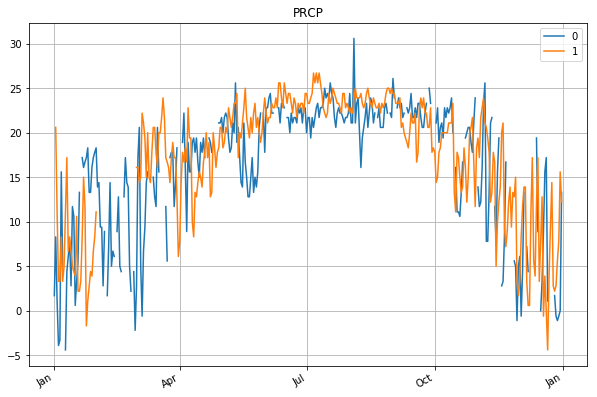

In [6]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [7]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/charu/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


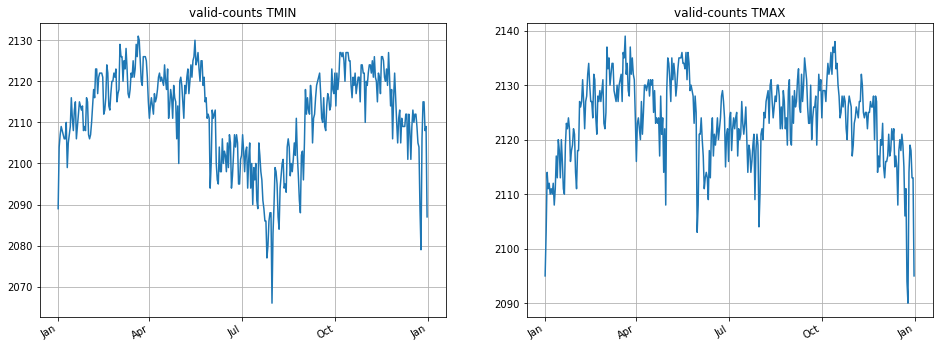

In [8]:
plot_pair(['TMIN','TMAX'],plot_valid)

In [9]:
# Most dip in august/sept and Dec/jan??
# Is it beacuse its hard to measuer snow depth.precipiation during peak summer?

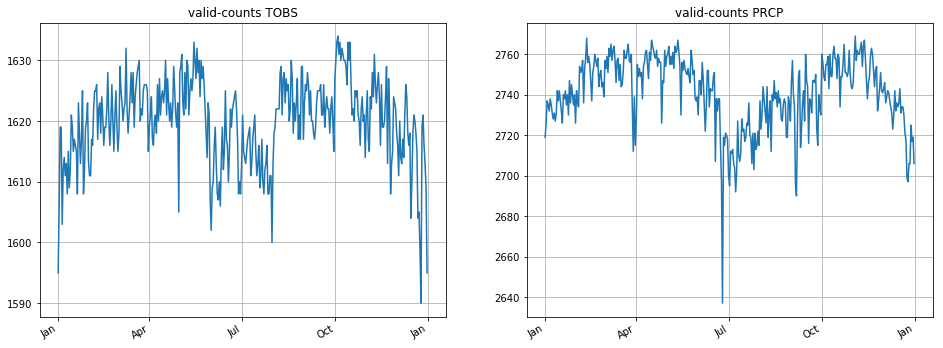

In [10]:
plot_pair(['TOBS','PRCP'],plot_valid)

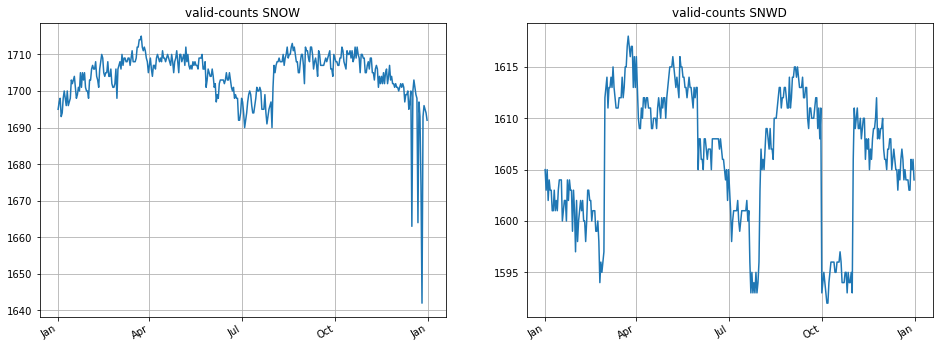

In [11]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [12]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    print mean[0]
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m,ylbl='Millimeter')

103.510770704
220.917899761


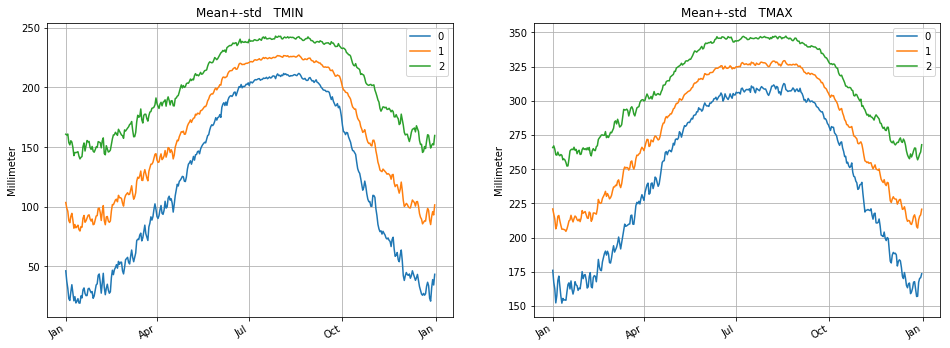

In [13]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

165.589968652
25.208900331


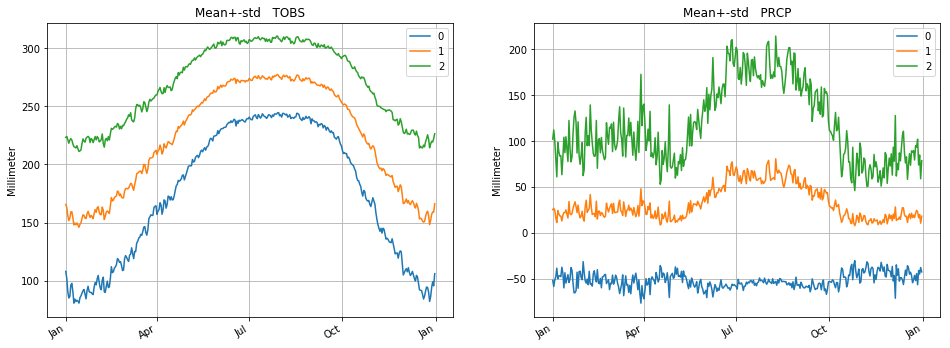

In [14]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

0.0
0.0473520249221


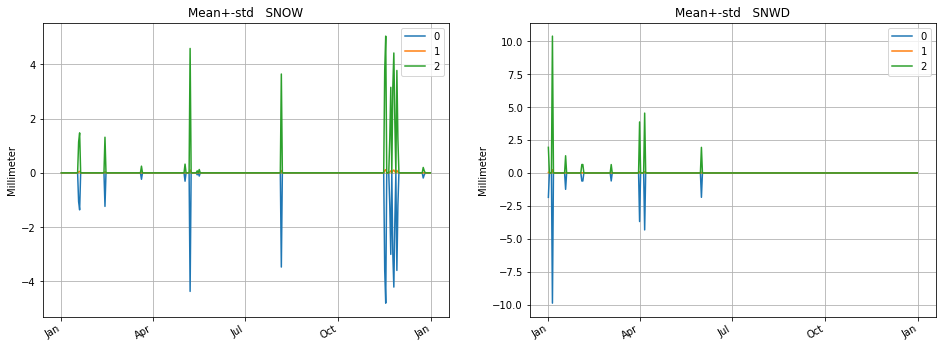

In [15]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [16]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

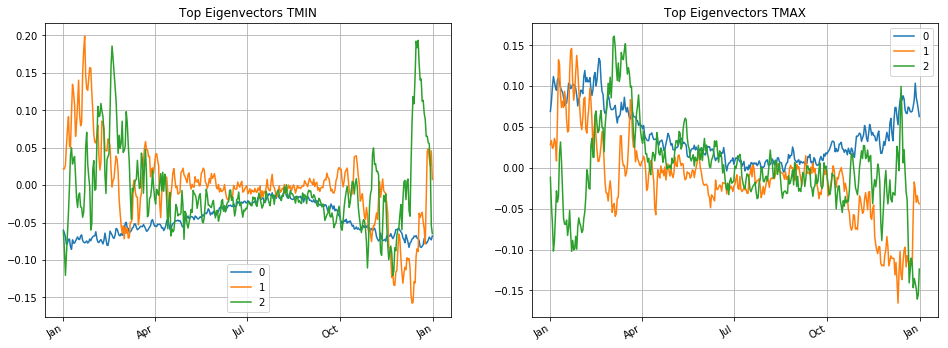

In [17]:
plot_pair(['TMIN','TMAX'],plot_eigen)

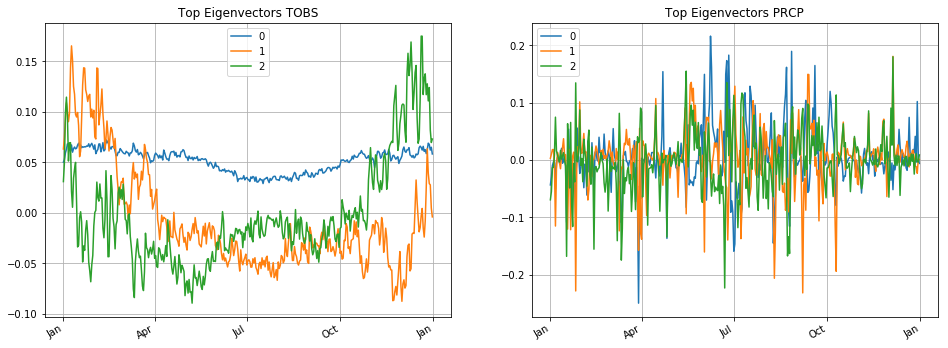

In [18]:
plot_pair(['TOBS','PRCP'],plot_eigen)

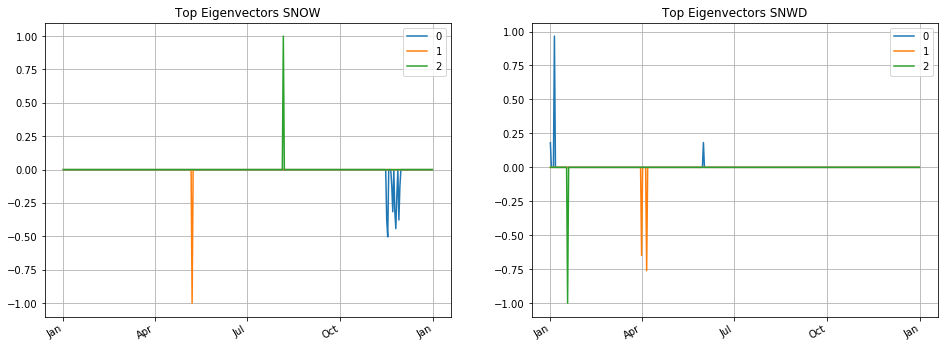

In [19]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [20]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

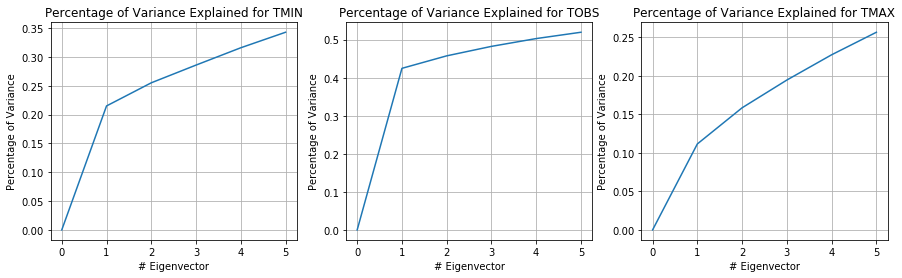

In [21]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

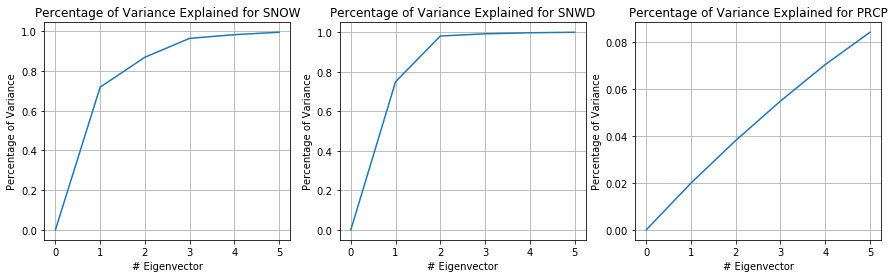

In [22]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [23]:
#sc.stop()

In [24]:
STAT['TOBS']['eigval']

array([  3.67195537e+05,   2.83774608e+04,   2.15354615e+04,
         1.77286446e+04,   1.43758118e+04,   1.33002942e+04,
         1.30042317e+04,   1.05533054e+04,   1.04058224e+04,
         9.73344780e+03,   9.05997512e+03,   8.43359359e+03,
         8.51928320e+03,   8.09904065e+03,   7.85409389e+03,
         7.29178592e+03,   7.32770432e+03,   6.73137159e+03,
         6.60200305e+03,   6.39977156e+03,   6.21461406e+03,
         6.13556376e+03,   5.94389129e+03,   5.60887845e+03,
         5.45713114e+03,   5.26384844e+03,   5.08866972e+03,
         4.97111918e+03,   4.86696452e+03,   4.59131494e+03,
         4.55152592e+03,   4.43269856e+03,   4.32156597e+03,
         4.12018458e+03,   4.06055060e+03,   4.02129103e+03,
         3.84896973e+03,   3.78929679e+03,   3.67508210e+03,
         3.64534686e+03,   3.54692235e+03,   3.45410164e+03,
         3.36974536e+03,   3.34345021e+03,   3.25903557e+03,
         3.09690604e+03,   3.07730909e+03,   2.97165509e+03,
         2.91936218e+03,

In [36]:
#Ks Test

mean=STAT['TMIN']['Mean'] / 10
x=0
min_temp=[]
while(x<365):
    temp=np.mean(np.array(mean[x:x+31]))
    min_temp.append(temp)
    x+=31


mean=STAT['TMAX']['Mean'] / 10
x=0
max_temp=[]
while(x<365):
    temp=np.mean(np.array(mean[x:x+31]))
    max_temp.append(temp)
    x+=31


MIN=[4.6,5.8,8.8,11.8,15.8,19.6,20.9,20.9,20,15.1,10,6.1]
MAX=[18.6,19.8,23.4,26.1,29.7,31.8,32.7,32.3,30.8,27.1,23.1,19.5]

    


print min_temp
print max_temp

from scipy.stats import ks_2samp
print ks_2samp(min_temp, MIN)
print ks_2samp(max_temp, MAX)

[8.857521519097812, 9.943758826758291, 12.596241540163417, 15.326923228917391, 18.766277716265357, 21.651095193586897, 22.474525050960736, 22.462304683361303, 21.128644821283807, 16.500253799441506, 11.786306298193168, 9.5598878820263042]
[21.213780532086606, 22.430256189469763, 25.273282428977012, 28.140215952458039, 31.067998950085446, 32.388780148125612, 32.706956806301001, 32.67810328290394, 31.349054642724543, 27.953857523817231, 24.207086915556438, 21.658460592619747]
Ks_2sampResult(statistic=0.33333333333333337, pvalue=0.43330893681048599)
Ks_2sampResult(statistic=0.25, pvalue=0.78641716217514468)


In [26]:
Query="SELECT latitude,longitude FROM weather\n\t"
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
lat,lon = [],[]
for row in df1.collect():
    lat.append(row[0])
    lon.append(row[1])

12089 rows


In [34]:
import gmplot
gmap = gmplot.GoogleMapPlotter(29, -82, 100)
gmap.scatter(lat, lon, marker=True,color='red')
gmap.draw("map.html")

In [33]:
m = 'TOBS'
Mean=STAT[m]['Mean']
print "Coefficient of variation for Mean distribution ",np.std(Mean) / np.mean(Mean)
print "Coefficient of variation for eig1 distribution ",np.std(STAT[m]['eigvec'][:,0]) / np.mean(STAT[m]['eigvec'][:,0])

Coefficient of variation for Mean distribution  0.204697937616
Coefficient of variation for eig1 distribution  0.2180259965
